<a href="https://colab.research.google.com/github/weltonfelix/deep_project/blob/main/deteccao_discurso_de_odio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória Inicial dos Dados

## Downloads e bibliotecas

In [2]:
!pip install d2l==1.0.3 -q

In [3]:
pip install pandas -q

In [4]:
pip install datasets -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 1.0.3 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [5]:
pip install scipy -q

In [6]:
pip install ntlk -q

ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


In [7]:
pip install spacy -q

In [8]:
pip install emoji -q

In [9]:
pip install d2l -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires requests>=2.32.2, but you have requests 2.31.0 which is incompatible.


In [10]:
import warnings

import datasets
import matplotlib.pyplot as plt
import math
import scipy.stats as ss

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import torch.optim as optim
import pandas as pd
import numpy as np
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from d2l import torch as d2l

import re
import nltk
import spacy
import emoji
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [11]:
nltk.download('stopwords')
warnings.filterwarnings('ignore', category=RuntimeWarning) # ignora avisos de runtime para evitar poluição do output
pd.set_option('display.max_columns', None) # print all columns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carregando o dataset

In [12]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech')
df = dataset['train'].to_pandas()
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,no,college_grad_ba,<10k,neutral,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,25.0,False,False,True,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,False,False,False,False,False,False,False

## Mudando valores booleanos para valores numéricos (0 e 1)

In [13]:
df = df.replace({True: 1.0, False: 0.0})
df

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,college_grad_ba,<10k,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_coll

## Descrição geral do dataset

In [14]:
df.describe(include="all")

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.0000

## Verificar a existência de valores NAN (not a number) indesejados

In [15]:
nan_count = df.isna().sum()

for column, count in nan_count.items():
  if count > 0:
    print(f"{column}: {count} NAN values")

annotator_educ: 17 NAN values
annotator_income: 103 NAN values
annotator_ideology: 27 NAN values
annotator_age: 105 NAN values


##### Como existe alguns valores NAN nessas colunas, é necessário realizar alguma modificação nos dados a fim de excluir esses valores. Como foram poucos, é possível simplesmente retirar as linhas que possuem coluna(s) com esse valor, com uma redução insignificante, menos de 0.2% do dataset

## Analisando esses valores NAN

In [16]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
1550,46976,2439,3,4.0,4.0,4.0,4.0,2.0,2.0,0.0,0.0,4.0,1.0,-0.68,@Bloodwolfz4 Sorry could not end my comment. C...,1.48,1.10,0.03,0.34,1.16,0.79,-0.689445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,some_college,None,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2488,35314,9226,2,4.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,-2.07,"all i know is, if you put your hands on a woma...",1.68,1.60,0.37,0.36,0.69,0.51,0.227088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prefer_not_to_say

##### A remoção desses valores realmente não terá um impacto negativo no dataset. Logo, é possível realizar a retirada deles tranquilamente

## Excluindo colunas com valores NAN

In [17]:
df.dropna(subset=["annotator_educ", "annotator_income", "annotator_ideology", "annotator_age"], inplace=True)
df

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,college_grad_ba,<10k,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_coll

## Retirando as duas primeiras colunas (inúteis)

In [18]:
df.drop(["comment_id", "annotator_id"], axis=1, inplace=True)
df.head()

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,college_grad_ba,<10k,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_college,<10k,neutral,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.

##### Elas importavam apenas para a identificação de quem estava escrevendo os textos, que além de serem números únicos, sem repetição, não iriam influenciar o treinamento dos modelos

## Análise do balanceamento entre as classes das colunas categóricas

In [19]:
for column in df.columns:
    if column not in ["infitms", "outfitms", "annotator_severity", "std_err", "annotator_infitms", "annotator_outfitms", "hypothesis", "text", "hate_speech_score"]: # colunas não categóricas
      print(f"Column: {column}")
      value_counts = df[column].value_counts(normalize=True) * 100 # valor em percentagem
      print(value_counts)
      print("\n")

Column: platform
platform
1    31.891305
0    27.419712
2    25.838331
3    14.850651
Name: proportion, dtype: float64


Column: sentiment
sentiment
4.0    45.323071
3.0    25.999350
2.0    14.586965
0.0     7.126924
1.0     6.963690
Name: proportion, dtype: float64


Column: respect
respect
4.0    43.135285
3.0    22.661536
2.0    17.621946
0.0     9.475729
1.0     7.105504
Name: proportion, dtype: float64


Column: insult
insult
4.0    32.570833
3.0    29.267734
2.0    13.703578
0.0    13.636364
1.0    10.821491
Name: proportion, dtype: float64


Column: humiliate
humiliate
3.0    29.048365
4.0    22.332112
2.0    18.464709
0.0    15.724436
1.0    14.430378
Name: proportion, dtype: float64


Column: status
status
2.0    45.100747
3.0    26.874612
4.0    23.977753
1.0     3.142081
0.0     0.904807
Name: proportion, dtype: float64


Column: dehumanize
dehumanize
0.0    23.516855
3.0    21.130381
1.0    20.989305
2.0    18.634591
4.0    15.728868
Name: proportion, dtype: float64


Colum

##### Com essas informações, podemos utilizar algumas técnicas para balancear as classes na etapa de processamento dos dados e aplicação de técnicas mais complexas

## Análise do balanceamento entre os valores das colunas numéricas

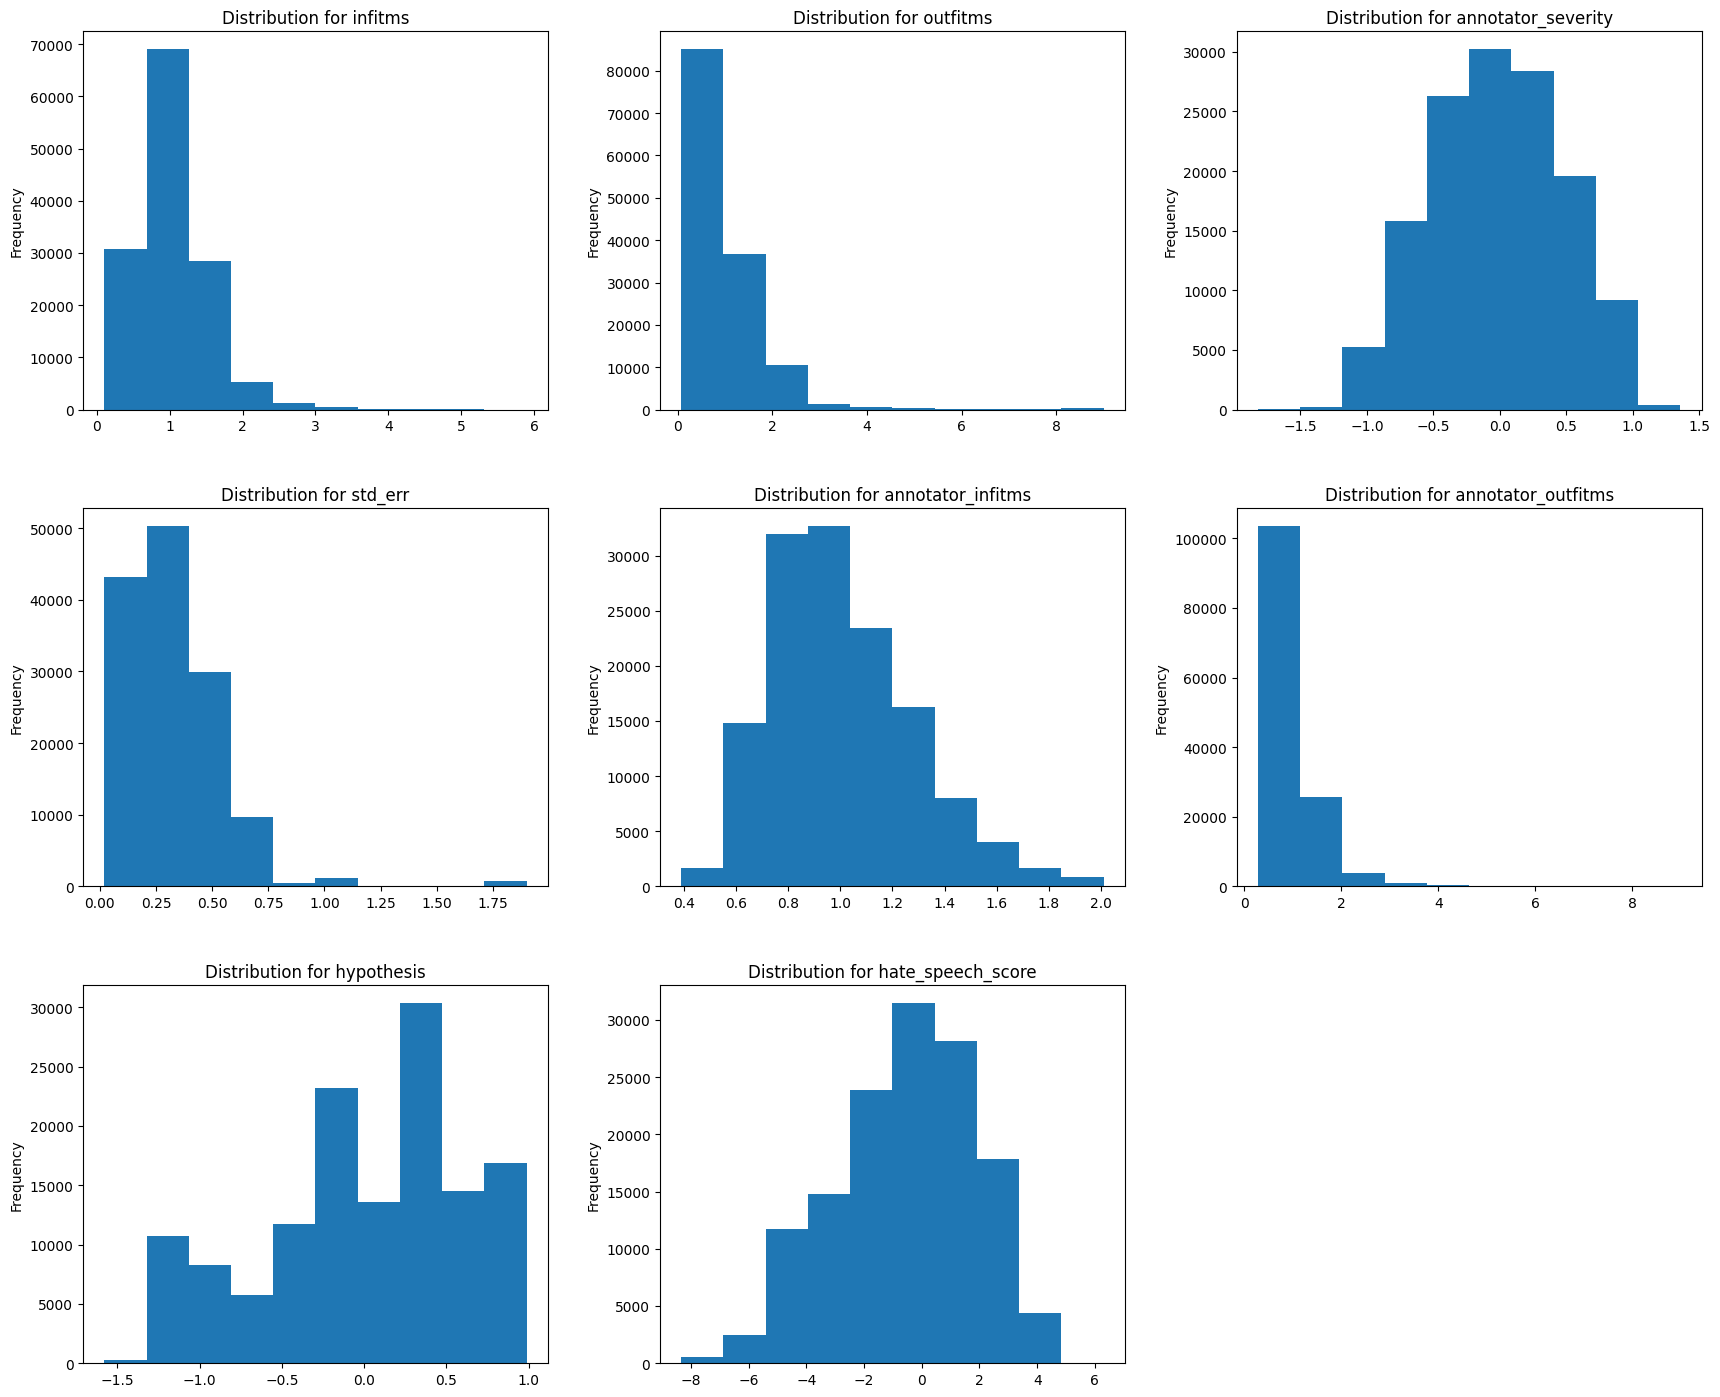

In [20]:
columns_to_plot = [
    "infitms", "outfitms", "annotator_severity", "std_err",
    "annotator_infitms", "annotator_outfitms", "hypothesis", "hate_speech_score"
] # colunas numéricas

# determinando o tamanho do grid
num_columns = len(columns_to_plot)
num_rows = math.ceil(num_columns / 3)

# criando o grid
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, num_rows * 5))
fig.tight_layout(pad=5.0)

axes = axes.flatten() # ajeitando os eixos, se necessário

for ax, column in zip(axes, columns_to_plot): # plotando o histograma pra cada coluna
    df[column].plot(kind='hist', ax=ax, title=f'Distribution for {column}', bins=10)
    ax.set_ylabel('Frequency')

for i in range(num_columns, len(axes)): # removendo subplots vazios
    fig.delaxes(axes[i])

plt.show()

## Detecção de outliers e remoção deles dependendo da quantidade

In [21]:
def calcular_limites_outliers(data):
    Q1 = data.quantile(0.25)  # primeiro quartil (25%)
    Q3 = data.quantile(0.75)  # terceiro quartil (75%)
    IQR = Q3 - Q1  # intervalo interquartil (IQR)
    limite_inferior = Q1 - 1.5 * IQR  # limite inferior para outliers
    limite_superior = Q3 + 1.5 * IQR  # limite superior para outliers
    return limite_inferior, limite_superior


for column in ["infitms", "outfitms", "annotator_severity", "std_err", "annotator_infitms", "annotator_outfitms", "hypothesis", "hate_speech_score"]:
    limite_inferior, limite_superior = calcular_limites_outliers(df[column]) # limites inferior e superior de outliers para a coluna atual
    outliers = df[(df[column] < limite_inferior) | (df[column] > limite_superior)] # identifica as linhas do dataset que são outliers
    print(f"Número de outliers da coluna {column}: {outliers.shape[0]}")

    if outliers.shape[0] < 1000: # threshold
        df = df[(df[column] >= limite_inferior) & (df[column] <= limite_superior)] # remove os outliers do dataset
        print("Outliers removidos")

Número de outliers da coluna infitms: 3595
Número de outliers da coluna outfitms: 5377
Número de outliers da coluna annotator_severity: 19
Outliers removidos
Número de outliers da coluna std_err: 1293
Número de outliers da coluna annotator_infitms: 2224
Número de outliers da coluna annotator_outfitms: 8424
Número de outliers da coluna hypothesis: 4
Outliers removidos
Número de outliers da coluna hate_speech_score: 41
Outliers removidos


In [22]:
df

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,college_grad_ba,<10k,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_college,<10k,neutral,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.

## Análise de correlação entre colunas

In [22]:
# NNN, n rodar essa parte pro resto rodar mais rapido (isso aq é so uma analise)

'''def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y) # Cria uma matriz de confusão para as variáveis x e y
    chi2 = ss.chi2_contingency(confusion_matrix)[0] # calcula o valor do teste qui-quadrado
    n = confusion_matrix.sum().sum() # calcula o número total de observações
    r, k = confusion_matrix.shape  # pega o número de linhas e colunas da matriz de confusão
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))  # calcula e retorna o valor de Cramers V

threshold = 0.9 # correlação muito alta
for coluna1 in df.columns:
  for coluna2 in df.columns:
    if coluna1 != coluna2 and coluna1 != "text" and coluna2 != "text" and coluna1 != "hypothesis" and coluna2 != "hypothesis":
      correlacao = cramers_v(df[coluna1], df[coluna2])
      if correlacao >= threshold:
        print(f"Correlação entre {coluna1} e {coluna2}: {correlacao}")'''

'def cramers_v(x, y):\n    confusion_matrix = pd.crosstab(x, y) # Cria uma matriz de confusão para as variáveis x e y\n    chi2 = ss.chi2_contingency(confusion_matrix)[0] # calcula o valor do teste qui-quadrado\n    n = confusion_matrix.sum().sum() # calcula o número total de observações\n    r, k = confusion_matrix.shape  # pega o número de linhas e colunas da matriz de confusão\n    return np.sqrt(chi2 / (n * (min(r, k) - 1)))  # calcula e retorna o valor de Cramers V\n\nthreshold = 0.9 # correlação muito alta\nfor coluna1 in df.columns:\n  for coluna2 in df.columns:\n    if coluna1 != coluna2 and coluna1 != "text" and coluna2 != "text" and coluna1 != "hypothesis" and coluna2 != "hypothesis":\n      correlacao = cramers_v(df[coluna1], df[coluna2])\n      if correlacao >= threshold:\n        print(f"Correlação entre {coluna1} e {coluna2}: {correlacao}")'

##### Essas colunas que possuem alta correlação podem ser removidas (apenas uma delas) futuramente para evitar a redundância de features e fazendo com que os modelos rodem em um tempo mais rápido. Essa remoção não foi feita agora, pois é importante avaliar na prática se não há perca de eficiência na prática quando essas remoções são realizadas

# Pre-processamento dos dados usando NLP

## Removendo emojis e caracteres especiais

In [23]:
def remove_special(text):
    for char in text: #Removendo caracteres especiais
      if ord(char.upper()) not in range(65, 91) and ord(char) != 32:
        text = text.replace(char, "")
    return ''.join(char for char in text if char not in emoji.EMOJI_DATA) #Removendo emojis

df['clean_text'] = df['text'].apply(remove_special)

In [24]:
df[['text', 'clean_text']]

,text,clean_text
0,Yes indeed. She sort of reminds me of the elde...,Yes indeed She sort of reminds me of the elder...
1,The trans women reading this tweet right now i...,The trans women reading this tweet right now i...
2,Question: These 4 broads who criticize America...,Question These broads who criticize America w...
3,It is about time for all illegals to go back t...,It is about time for all illegals to go back t...
4,For starters bend over the one in pink and kic...,For starters bend over the one in pink and kic...
...,...,...
135551,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,BreakingNews Sayyed AbdulmalikT...
135552,Millions of #Yemen-is participated in mass ral...,Millions of Yemenis participated in mass ralli...
135553,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,AbeShinzo realDonaldTrump shinzoabe Dictator ...
135554,Millions of #Yemen-is participated in mass ral...,Millions of Yemenis participated in mass ralli...


## Removendo as stopwords

In [25]:
#Converter a coluna em um array
textos = df['text'].values

def remove_stopwords(text):
      stop_words = set(stopwords.words('english'))
      words = text.split()
      filtered_words = [word for word in words if word.lower() not in stop_words]
      return ' '.join(filtered_words)

df['no_stopwords'] = df['clean_text'].apply(remove_stopwords)

In [26]:
df[['text', 'clean_text', 'no_stopwords']]

,text,clean_text,no_stopwords
0,Yes indeed. She sort of reminds me of the elde...,Yes indeed She sort of reminds me of the elder...,Yes indeed sort reminds elder lady played part...
1,The trans women reading this tweet right now i...,The trans women reading this tweet right now i...,trans women reading tweet right beautiful
2,Question: These 4 broads who criticize America...,Question These broads who criticize America w...,Question broads criticize America country flee...
3,It is about time for all illegals to go back t...,It is about time for all illegals to go back t...,time illegals go back country origin keep free...
4,For starters bend over the one in pink and kic...,For starters bend over the one in pink and kic...,starters bend one pink kick ass pussy get tast...
...,...,...,...
135551,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,BreakingNews Sayyed AbdulmalikT...,BreakingNews Sayyed AbdulmalikThe Saudi regime...
135552,Millions of #Yemen-is participated in mass ral...,Millions of Yemenis participated in mass ralli...,Millions Yemenis participated mass rallies squ...
135553,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,AbeShinzo realDonaldTrump shinzoabe Dictator ...,AbeShinzo realDonaldTrump shinzoabe Dictator g...
135554,Millions of #Yemen-is participated in mass ral...,Millions of Yemenis participated in mass ralli...,Millions Yemenis participated mass rallies squ...


###Criando categorias para a coluna hate_speech_score

In [27]:
bins = [-1000, -1, 1, 1000]
labels = ["Normal", "Neutral", "Hate Speech"]

df['hate_speech_score_binned'] = pd.cut(df['hate_speech_score'], bins=bins, labels=labels)
df.head()

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,clean_text,no_stopwords,hate_speech_score_binned
0,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,no,college_grad_ba,<10k,neutral,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes indeed She sort of reminds me of the elder...,Yes indeed sort reminds elder lady played part...,Normal
1,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.

#### Codificação de label

In [28]:
# Codificar os rótulos
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['hate_speech_score_binned'])

#### Divisão dos dados

In [29]:
# Dividir o dataset em treinamento e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

### Lematização

In [30]:
nlp = spacy.load('en_core_web_sm') # Usando spaCy em vez do nltk para aplicar a lematização por ser mais eficiente

def lemmatize_text(text):
    lemmatized_text = []
    for doc in nlp.pipe(text, batch_size=50, n_process=-1): # Usar a biblioteca spacy aplicar processamento paralelo reduziu o tempo de execução dessa parte pela metade
        lemmatized_text.append(' '.join([token.lemma_ for token in doc]))
    return lemmatized_text

train_df['lemmatized_text'] = lemmatize_text(train_df['no_stopwords'])
test_df['lemmatized_text'] = lemmatize_text(test_df['no_stopwords'])

In [31]:
train_df

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,clean_text,no_stopwords,hate_speech_score_binned,label,lemmatized_text
84887,2,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,3.0,2.0,0.92,"Told the bitch shut up, you about to fuck my n...",0.84,0.82,-0.54,0.38,1.08,0.86,0.230014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_college,50k-100k,liberal,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Told the bitch shut up you about to fuck my nu...,Told bitch shut fuck nut,Neutral,1,tell bitch shut fuck nut
107805,1,4.0,0.0,4.0,4.0,4.0,4.0,1.0,0.0,4.0,1.0,1.42,GEEZ..... I think #NorthKorea may be right. #B...,0.93,0.92,0.95,0.03,1.75,1.24,0.504897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

#### Tokenização do texto

In [32]:
# Função para tokenizar o texto
tokenizer = get_tokenizer("basic_english")

def tokenize(text):
    return tokenizer(text)

# Aplicar a tokenização ao dataframe
train_df['tokens'] = train_df['lemmatized_text'].apply(tokenize)
test_df['tokens'] = test_df['lemmatized_text'].apply(tokenize)

In [33]:
train_df

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,clean_text,no_stopwords,hate_speech_score_binned,label,lemmatized_text,tokens
84887,2,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,3.0,2.0,0.92,"Told the bitch shut up, you about to fuck my n...",0.84,0.82,-0.54,0.38,1.08,0.86,0.230014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,no,some_college,50k-100k,liberal,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Told the bitch shut up you about to fuck my nu...,Told bitch shut fuck nut,Neutral,1,tell bitch shut fuck nut,"[tell, bitch, shut, fuck, nut]"
107805,1,4.0,0.0,4.0,4.0,4.0,4.0,1.0,0.0,4.0,1.0,1.42,GEEZ..... I think #NorthKorea may be right. #B...,0.93,0.92,0.95,0.03,1.75,1.24,0.504897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

### Aplicando One-Hot Encoder, transformando tudo exceto os tokens em números

In [34]:
#Usando pandas get_dummies para One-Hot Encoding
hot_columns = []

for df in [train_df, test_df]:
  for column in df:
    if df[column].dtype == "bool":
      hot_columns.append(column)

train_hot = pd.get_dummies(train_df, columns=hot_columns)
test_hot = pd.get_dummies(test_df, columns=hot_columns)

for df in [train_df, test_df]:
  for column in df:
    if df[column].dtype == "bool" or df[column].dtype == "string":
      hot_columns.append(column)


for df in [train_hot, test_hot]:
  try: # tava dando problema se nao usasse isso aqui, mas acho que é porque eu tava no meio da execução, acho que nao precisa
    df.drop(['text', 'clean_text', 'no_stopwords', 'lemmatized_text', 'hate_speech_score_binned', 'annotator_gender',	'annotator_trans', 'annotator_educ', 'annotator_income', 'annotator_ideology'], axis=1, inplace=True)
  except:
    pass

train_hot.head()


,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,label,tokens
84887,2,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,3.0,2.0,0.92,0.84,0.82,-0.54,0.38,1.08,0.86,0.230014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,"[tell, bitch, shut, fuck, nut]"
107805,1,4.0,0.0,4.0,4.0,4.0,4.0,1.0,0.0,4.0,1.0,1.42,0.93,0.92,0.95,0.03,1.75,1.24,0.504897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,"[geez, think, northkorea, may, 

#### Construção do vocabulário

In [35]:
# Construir vocabulário
def yield_tokens(data):
    for tokens in data:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(train_hot['tokens']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

### Transformando todos os números em um só tipo

In [36]:
for column in train_hot.columns:
  if column != "tokens":
    for df in [train_hot, test_hot]:
      df[column] = df[column].astype(np.float32)

#for column in train_hot:
  #print(train_hot[column].dtype)

### Transforma tokens em sequências numéricas que conseguem ser passadas pro modelo

In [37]:
for df in [train_hot, test_hot]:

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['tokens'])
    sequences = tokenizer.texts_to_sequences(df['tokens'])

    maxlen = 0
    for seq in sequences:
      if len(seq) > maxlen:
        maxlen = len(seq)

    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    padded_sequences = np.array(padded_sequences, dtype=np.float32)

    df['padded_sequences'] = list(padded_sequences)

<ipython-input-37-d76366fc53af>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['padded_sequences'] = list(padded_sequences)
<ipython-input-37-d76366fc53af>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['padded_sequences'] = list(padded_sequences)


#### Colocando as sequências como listas pra serem usadas pelos modelos

In [38]:
train_sequences = np.array(train_hot['padded_sequences'].tolist(), dtype=np.float32)
test_sequences = np.array(test_hot['padded_sequences'].tolist(), dtype=np.float32)

### Retirando colunas agora desnecessárias

In [39]:
for df in [train_hot, test_hot]:
  df.drop(["tokens"], axis=1, inplace=True)
  df.drop(["padded_sequences"], axis=1, inplace=True)

train_hot

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,label
84887,2.0,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,3.0,2.0,0.92,0.84,0.82,-0.54,0.38,1.08,0.86,0.230014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
107805,1.0,4.0,0.0,4.0,4.0,4.0,4.0,1.0,0.0,4.0,1.0,1.42,0.93,0.92,0.95,0.03,1.75,1.24,0.504897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9531,0.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,-1.33,0.65,0.55

### Setando colunas que serão usadas pelo modelo pra prever

In [40]:
feature_columns = []

for column in train_hot.columns:
  if column not in ["label", "tokens", "padded_sequences"]:
    feature_columns.append(column)

### Criação dos datasets (GERAL PRA TODOS OS MODELOS)

In [41]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, df, feature_columns):
        self.sequences = sequences
        self.df = df
        self.feature_columns = feature_columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = self.df.iloc[idx]['label']
        additional_features = torch.tensor(self.df.iloc[idx][self.feature_columns].values, dtype=torch.float32)
        return sequence, additional_features, label

# Atualizar criação dos datasets
train_dataset = HateSpeechDataset(train_sequences, train_hot, feature_columns)
test_dataset = HateSpeechDataset(test_sequences, test_hot, feature_columns)

In [42]:
def collate_fn(batch):
    sequences, additional_features, labels = zip(*batch)
    sequences = pad_sequence(sequences, batch_first=True, padding_value=0)  # Use padding value 0 for sequences
    additional_features = torch.stack(additional_features)
    labels = torch.tensor([int(label) for label in labels], dtype=torch.long)
    return sequences, additional_features, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Treinamento (GRU)

#### Criando a GRU

In [43]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_features, num_classes=3):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.gru = nn.GRU(num_hiddens, num_hiddens, batch_first=True)
        self.fc = nn.Linear(num_hiddens + num_features, num_classes)

    def forward(self, inputs, additional_features):
        embedded = self.embedding(inputs)
        output, _ = self.gru(embedded)
        output = output[:, -1, :]  # Use the output of the last time step
        combined = torch.cat((output, additional_features), dim=1)
        output = self.fc(combined)
        return output

# Definir parâmetros do modelo
num_inputs = len(vocab)
num_hiddens = 32
num_features = len(feature_columns)
gru_model = GRUModel(vocab_size=num_inputs, num_hiddens=num_hiddens, num_features=num_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

#### Função para calcular as métricas (GERAL PRA TODOS OS MODELOS)

In [43]:
def calculate_metrics(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(labels, predicted)
    precision = precision_score(labels, predicted, average='weighted')
    f1 = f1_score(labels, predicted, average='weighted')
    auc_roc = roc_auc_score(labels, nn.functional.softmax(outputs, dim=1), multi_class='ovr')
    return accuracy, precision, f1, auc_roc

#### Treinamento do modelo

In [45]:
num_epochs = 10
for epoch in range(num_epochs):
    gru_model.train()
    for inputs, additional_features, labels in train_loader:
        outputs = gru_model(inputs, additional_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Avaliação no conjunto de teste
    gru_model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, additional_features, labels in test_loader:
            outputs = gru_model(inputs, additional_features)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    accuracy, precision, f1, auc_roc = calculate_metrics(torch.tensor(all_outputs), torch.tensor(all_labels))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, F1-Score: {f1}, AUC-ROC: {auc_roc}')

Epoch 1/10, Loss: 0.9677196145057678, Accuracy: 0.8994642527249215, Precision: 0.9053219696495941, F1-Score: 0.9004285353858864, AUC-ROC: 0.9836513517847424
Epoch 2/10, Loss: 0.04432644322514534, Accuracy: 0.9283576574912248, Precision: 0.9278563764317386, F1-Score: 0.9279651417503286, AUC-ROC: 0.9887448188196073
Epoch 3/10, Loss: 0.010486702434718609, Accuracy: 0.9277295399963051, Precision: 0.9272959238236085, F1-Score: 0.927429888454369, AUC-ROC: 0.987669509206326
Epoch 4/10, Loss: 5.205451543588424e-06, Accuracy: 0.9090707555883983, Precision: 0.9082885682801121, F1-Score: 0.9076955800565863, AUC-ROC: 0.9834812318260093
Epoch 5/10, Loss: 0.000788586272392422, Accuracy: 0.9232218732680584, Precision: 0.9234367937813978, F1-Score: 0.9233164506722363, AUC-ROC: 0.9869319323112312


KeyboardInterrupt: 

###BiLSTM

In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, df, feature_columns):
        self.sequences = sequences
        self.df = df
        self.feature_columns = feature_columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = self.df.iloc[idx]['label']
        additional_features = torch.tensor(self.df.iloc[idx][self.feature_columns].values, dtype=torch.float32)
        return sequence, additional_features, label

# Atualizar criação dos datasets
train_dataset = HateSpeechDataset(train_sequences, train_hot, feature_columns)
test_dataset = HateSpeechDataset(test_sequences, test_hot, feature_columns)

def collate_fn(batch):
    sequences, additional_features, labels = zip(*batch)
    sequences = pad_sequence(sequences, batch_first=True, padding_value=0)  # Use padding value 0 for sequences
    additional_features = torch.stack(additional_features)
    labels = torch.tensor([int(label) for label in labels], dtype=torch.long)  # Convert labels to long for CrossEntropyLoss
    return sequences, additional_features, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_features, num_classes=3):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.bilstm = nn.LSTM(num_hiddens, num_hiddens, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(num_hiddens * 2 + num_features, num_classes)

    def forward(self, inputs, additional_features):
        embedded = self.embedding(inputs)
        output, _ = self.bilstm(embedded)
        output = output[:, -1, :]  # Use the output of the last time step
        combined = torch.cat((output, additional_features), dim=1)
        output = self.fc(combined)
        return output

# Definir parâmetros do modelo
num_inputs = len(vocab)
num_hiddens = 32
num_features = len(feature_columns)
bilstm_model = BiLSTMModel(vocab_size=num_inputs, num_hiddens=num_hiddens, num_features=num_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.001)

def calculate_metrics(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
    precision = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    auc_roc = roc_auc_score(labels.cpu().numpy(), nn.functional.softmax(outputs, dim=1).cpu().numpy(), multi_class='ovr')
    return accuracy, precision, f1, auc_roc

num_epochs = 10
for epoch in range(num_epochs):
    bilstm_model.train()
    for inputs, additional_features, labels in train_loader:
        outputs = bilstm_model(inputs, additional_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Avaliação no conjunto de teste
    bilstm_model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, additional_features, labels in test_loader:
            outputs = bilstm_model(inputs, additional_features)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    accuracy, precision, f1, auc_roc = calculate_metrics(torch.tensor(all_outputs), torch.tensor(all_labels))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, F1-Score: {f1}, AUC-ROC: {auc_roc}')


Epoch 1/10, Loss: 0.007459429558366537, Accuracy: 0.903787179013486, Precision: 0.9060883313484439, F1-Score: 0.9044108815937822, AUC-ROC: 0.9828681478597628
Epoch 2/10, Loss: 0.044361162930727005, Accuracy: 0.9322741548124884, Precision: 0.9355676190627195, F1-Score: 0.9330719806000966, AUC-ROC: 0.9920826104277426
Epoch 3/10, Loss: 0.04201367124915123, Accuracy: 0.9371882505080362, Precision: 0.9367660267778947, F1-Score: 0.9368070846227958, AUC-ROC: 0.9922336251736249
